The mass spectrometry data files contain tens of thousands of intensity values for each pixel in the sample. Since this is such a high dimensionality for pixel-by-pixel analysis, it seems reasonable to reduce the dimensionality of the problem. One way to do this (though probably not the best way for this situation) is by an SVD dimension reduction, mathematically proven to be the optimal projection onto a lower dimensionality. This code demonstrates performing this process.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.io as sio
import scipy.linalg as la
import scipy.sparse as ssp
import warnings; warnings.simplefilter('ignore')

In [2]:
# Define initial parameters
directory = "../../DESI Data"

# Define the parameters for resampling
new_interval_count = int(1e5)
new_min, new_max = 100, 1000
new_z_axis = np.linspace(new_min, new_max, new_interval_count+1)

# Define parameters for storage of resampled spectra
max_spectra = 30000
spectrum_count = 0
spectra = np.zeros((new_interval_count+1, max_spectra))

# Iterate through all files in the given directory
for file in os.listdir(directory):
    # Initialize variables, including container for the 3-d tensor (image)
    image, z_axis = None, None
    x, y, z = None, None, None
    
    try:
        # The file.bin file has been causing problems.
        # Maybe replace or get rid of it?
        if file == "file.bin":
            print("Skipping", file)
            continue
        
        # Handle standard binary files (Agilent)
        if file.endswith('.bin'):
            f = open(directory + '/' + file, 'rb')
            data = np.fromfile(f, '<f4')
            x, y, z = [int(n) for n in data[:3]]
            image, z_axis = data[3:x*y*z + 3], data[-z:]
            image.shape = (y, x, z)
            image = image.transpose((1, 0, 2))

        # Handle MATLAB binary files (Bruker)
        elif file.endswith('.mat'):
            data = {}
            f = h5py.File(directory + '/' + file, 'r')
            for k, v in f.items():
                data[k] = np.array(v)
            image, z_axis = data['img'], data['imgZ'][0]
            x, y, z = [len((data[x] if x != 'imgZ' else data[x].T))
                    for x in ['imgX', 'imgY', 'imgZ']]
            image.shape = (z, x, y)
            image = image.transpose((1, 2, 0))

    except:
        print("Unable to open", file)
        continue
    
    # Initialize sparse matrix and calculate resampled m/z axis
    conversion_matrix = ssp.lil_matrix((new_interval_count+1, z))
    min_mask = np.append(z_axis[1:], np.inf) >= new_min
    max_mask = np.append(-np.inf, z_axis[min_mask][:-1]) <= new_max
    z_axis = z_axis[min_mask][max_mask]
  
    # Build the sparse matrix to perform resampling on the data array
    index = 0
    for z in new_z_axis:
        right = len(z_axis[z_axis <= z])
        left = right - 1
        left_dist, right_dist = z - z_axis[left], z_axis[right] - z
        conversion_matrix[index,left] = right_dist/(left_dist + right_dist)
        conversion_matrix[index,right] = left_dist/(left_dist + right_dist)
        index += 1
    conversion_matrix = ssp.csr_matrix(conversion_matrix)

    # Iterate through each pixel in the image, by row and then column
    index = 0
    for i in range(x):
        for j in range(y):
            # Add the given spectrum to the defined container.
            spectra[:,index] = conversion_matrix @ image[i][j]            
            index += 1
            spectrum_count += 1
    
    # Track progress through files
    print("Finished reading in file:", file)

# Appropriately resize the spectrum container
spectra = spectra[:,:spectrum_count]

Skipping file.bin
Finished reading in file: 9-6-18 A3D4M3 Slide 3 Brain 1.mat
Finished reading in file: brain_2.bin
Unable to open mattest.mat
Finished reading in file: 10-9-18 A2D16F3 brain 50um.mat
Finished reading in file: 8-24-18_agilent_brain.bin


In [3]:
# Mean shift the spectrum matrix, and calculate its SVD
mu = np.mean(spectra, axis=1)
spectra = (spectra.T - mu).T
U, S, V = la.svd(spectra[:,np.random.choice(spectrum_count,
        spectrum_count//10, replace=False)], False)

In [4]:
# Select a random spectrum to display
spectrum = random.randint(0, 1) # random.randint(0, spectrum_count)
spectrum

0

In [5]:
# Project a vector or matrix A into s-dimensional space
def project(A, s):
    return np.dot(U[:,:s].T, A)

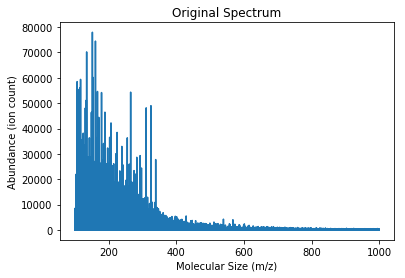

In [6]:
# Plot the original spectrum
plt.plot(new_z_axis, spectra[:,spectrum] + mu)
plt.title("Original Spectrum")
plt.xlabel("Molecular Size (m/z)")
plt.ylabel("Abundance (ion count)")
plt.show()

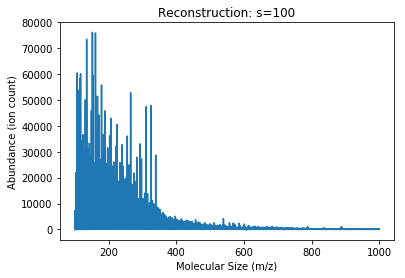

In [7]:
# Plot the reconstruction for s = 100
s = 100
reconstruction = U[:,:s]@project(spectra.T[spectrum], s)
plt.plot(new_z_axis, reconstruction + mu)
plt.title("Reconstruction: s=" + str(s))
plt.xlabel("Molecular Size (m/z)")
plt.ylabel("Abundance (ion count)")
plt.show()

In [8]:
# Save the projection of all spectra as a separate file
np.savez('projection', project(spectra, s))